In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Conv2D, multiply, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

2025-03-31 21:43:59.336259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743437639.431860    7560 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743437639.463991    7560 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-31 21:43:59.659938: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMAGE_SIZE = 128
BATCH_SIZE = 2  
CHANNELS = 3
n_classes = 5
EPOCHS = 100

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    r"Retina_Images",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2835 files belonging to 5 classes.


I0000 00:00:1743437646.480090    7560 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2278 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=50):
    ds_len=len(ds)
    
    train_size = int(train_split*ds_len)
    val_size = int(val_split*ds_len)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [5]:
TRAIN_DS,VAL_DS,TEST_DS = get_dataset_partitions_tf(dataset)
len(TRAIN_DS)

1134

In [6]:
len(TEST_DS)

143

In [7]:
len(VAL_DS)

141

In [8]:
IMAGE_SIZE = 128  # Define image size
RESIZE_AND_RESCALE = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255),
])

In [9]:
DATA_AUGMENTATION = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [10]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze pretrained layers

# Define model input
inputs = Input(shape=(128, 128, 3))

# Apply preprocessing and augmentation
x = RESIZE_AND_RESCALE(inputs)
x = DATA_AUGMENTATION(x)

# Pass through the ResNet50 base model
x = base_model(x, training=False)  # Keep batch normalization layers in inference mode

# Classification head
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dense(128, activation="relu")(x)
output = Dense(5, activation="softmax")(x)

# Define the final model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,145,797 (92.11 MB)

 Trainable params: 558,085 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
model.fit(
    TRAIN_DS,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=VAL_DS
)

Epoch 1/100


I0000 00:00:1743437677.320768    8095 cuda_dnn.cc:529] Loaded cuDNN version 90300


1134/1134 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.2844 - loss: 1.6066 - val_accuracy: 0.3156 - val_loss: 1.5906
Epoch 2/100
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.3196 - loss: 1.5703 - val_accuracy: 0.3121 - val_loss: 1.5694
Epoch 3/100
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.3198 - loss: 1.5636 - val_accuracy: 0.3227 - val_loss: 1.5629
Epoch 4/100
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.3214 - loss: 1.5637 - val_accuracy: 0.3121 - val_loss: 1.5703
Epoch 5/100
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.3205 - loss: 1.5638 - val_accuracy: 0.3156 - val_loss: 1.5670
Epoch 6/100
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.3211 - loss: 1.5632 - val_accuracy: 0.3156 - val_loss: 1.5658
Epoch 7/100
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.3212 - loss: 1.5634 - val_accuracy: 0.3191 - val_loss: 1.5622
Epoch 8/100
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.3201 - los

KeyboardInterrupt: 

In [39]:
class_names = dataset.class_names


In [57]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class , confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


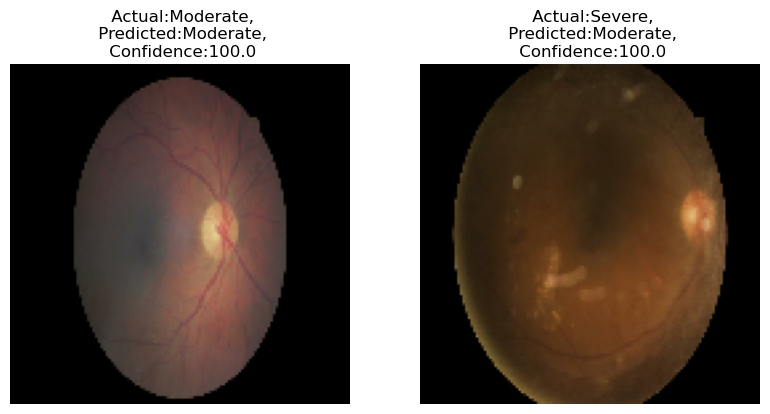

In [64]:
plt.figure(figsize=(15,15))
for images,labels in TEST_DS.take(1):
    for i in range(min(9, len(images))):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f" Actual:{actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}")
        plt.axis("off")
        

In [66]:
model_version = 1
model.export(f"/home/rhorschac/jnotebook/diabetic_retinopathy/MODEL/{model_version}")

INFO:tensorflow:Assets written to: /home/rhorschac/jnotebook/diabetic_retinopathy/MODEL/1/assets


INFO:tensorflow:Assets written to: /home/rhorschac/jnotebook/diabetic_retinopathy/MODEL/1/assets


Saved artifact at '/home/rhorschac/jnotebook/diabetic_retinopathy/MODEL/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_714')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  136204555717328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136204555717904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136204555718288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136204555718480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136204555715984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136204555717712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136204555722320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136204555722896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136204555723088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136204555721936: TensorSpec(shape=(), dtyp

In [2]:
pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 12.7 MB/s eta 0:00:00m eta 0:00:010:01:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
len(TEST_DS)

NameError: name 'TEST_DS' is not defined